In [1]:
import psycopg2 as psycopg
import boto3 # , boto3
import pandas as pd
import os, importlib
import mlflow

import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from category_encoders import CatBoostEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (confusion_matrix,
                             ConfusionMatrixDisplay,
                             precision_score,
                             recall_score,
                             f1_score,
                             log_loss,
                             roc_auc_score
                            )

In [2]:
from os import path

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
postgres_credentials = {
    "host":     (os.environ['DB_DESTINATION_HOST']),
    "port":     (os.environ['DB_DESTINATION_PORT']),
    "dbname":   (os.environ['DB_DESTINATION_NAME']),
    "user":     (os.environ['DB_DESTINATION_USER']),
    "password": (os.environ['DB_DESTINATION_PASSWORD'])
}
print(postgres_credentials)

{'host': 'rc1b-uh7kdmcx67eomesf.mdb.yandexcloud.net', 'port': '6432', 'dbname': 'playground_mle_20240226_38fc211d67', 'user': 'mle_20240226_38fc211d67', 'password': '3639df44fa6c4adf8f058988c14bee9a'}


In [5]:
# определяем название таблицы, в которой хранятся наши данные
TABLE_NAME = 'users_churn'
#connection = {"sslmode": "verify-full", "target_session_attrs": "read-write"}
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])
connection.update(postgres_credentials)

In [6]:
with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
				
				# извлекаем все строки, полученные в результате выполнения запроса
        data = cur.fetchall()

				# получаем список имён столбцов из объекта курсора
        columns = [col[0] for col in cur.description]

In [7]:
# создаём объект DataFrame из полученных данных и имён столбцов 
# это позволяет удобно работать с данными в Python с использованием библиотеки Pandas
data = pd.DataFrame(data, columns=columns)

Задание 1
Для начала создайте артефакты, к которым будет полезно всегда иметь быстрый доступ. Сюда могут входить: 
названия колонок в вашем датафрейме,
различные метрики, связанные с вашими данными,
сам датафрейм в формате CSV.
Сохраните названия колонок вашего датафрейма в текстовый файл, используя , как разделитель.

In [8]:
# 1. Название колонок вашего датафрейма запишите в текстовый файл
string=''
index=1
#print(data.columns)
for item in data.columns:
    #print(index,' ', str(item))
    index+=1
    if item!='target': string += str(item) + ',' 
    else: string += str(item)
#print(len(string))       
        
        
with open("columns.txt", "w", encoding="utf-8") as fio:
    fio.write(str(string))

Задание 2
Посчитайте различные статистики (минимальные, максимальные, средние и медианы) по вашему датафрейму для определённых колонок (count_columns) и запишите результат в Python-словарь. Для подсчёта воспользуйтесь функцией value_counts. Это нужно, чтобы понимать, на каких данных была обучена ваша модель.

In [9]:
counts_columns = [
    "type", "paperless_billing", "internet_service", "online_security", "online_backup", "device_protection",
    "tech_support", "streaming_tv", "streaming_movies", "gender", "senior_citizen", "partner", "dependents",
    "multiple_lines", "target"
]

stats = {}

for col in counts_columns:
    # посчитайте уникальные значения для колонок, где немного уникальных значений (переменная counts_columns)
    column_stat = data[col].value_counts()
    column_stat = {f"{col}_{key}": value for key, value in column_stat.items()}
    
    #обновите словарь stats
    stats.update(column_stat)

stats["data_length"] = data.shape[0]
stats["monthly_charges_min"] = data["monthly_charges"].min()
stats["monthly_charges_max"] = data["monthly_charges"].max() # посчитайте максимальное значение в колонке
stats["monthly_charges_mean"] = data["monthly_charges"].mean() # посчитайте среднее значение в колонке
stats["monthly_charges_median"] = data["monthly_charges"].median() # посчитайте медианное значение в колонке
stats["total_charges_min"] = data["total_charges"].min() # посчитайте минимальное значение в колонке
stats["total_charges_max"] = data["total_charges"].max() # посчитайте максимальное значение в колонке
stats["total_charges_mean"] = data["total_charges"].mean() # посчитайте среднее значение в колонке
stats["total_charges_median"] = data["total_charges"].median() # посчитайте медианное значение в колонке
stats["unique_customers_number"] = len(data["customer_id"].unique()) # посчитайте кол-во уникальных id
stats["end_date_nan"] = data["end_date"].isna().sum() # посчитайте кол-во пустых строк в колонке
print(stats["unique_customers_number"])

7043


Если в проекте есть такая возможность, а размер вашего датасета не превышает несколько гигабайт, то можно сохранить и сам датафрейм. Например, в формате CSV: 

In [10]:
data.to_csv("users_churn.csv", index=False) 

Задание 1
Напишите класс для кастомной регрессионой модели. Метод predict должен возвращать квадратный корень из предсказанного значения модели.

In [11]:
feature_cols = data.columns[1:]
is_duplicated_features = data.duplicated(subset=(feature_cols), keep=False)
print('Дубликаты до очистки:', len(data[is_duplicated_features]))
data = data[~is_duplicated_features].reset_index(drop=True) 
print('Дубликаты после очистки:',data.duplicated(keep=False).sum())

def fill_missing_values(data):
    cols_with_nans = data.isnull().sum()
    cols_with_nans = cols_with_nans[cols_with_nans > 0].index.drop('end_date')
    for col in cols_with_nans:
        if data[col].dtype in [float, int]:
            fill_value = data[col].mean()
        elif data[col].dtype == 'object':
            fill_value = data[col].mode().iloc[0]
        data[col] = data[col].fillna(fill_value)
    return data 
data = fill_missing_values(data)

num_cols = data.select_dtypes(['float']).columns
threshold = 1.5
potential_outliers = pd.DataFrame()
for col in num_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    margin = threshold*IQR
    lower = Q1 - margin
    upper = Q3 + margin 
    potential_outliers[col] = ~data[col].between(lower, upper)
outliers = potential_outliers.any(axis=1)
print(data[outliers])

# вставлять в MLFLOW от сих ...
data = data.drop('end_date',axis=1) # УТЕЧКА БУДЕТ ЕСЛИ НЕ УБРАТЬ
cat_features = data.select_dtypes(include='object')
potential_binary_features = cat_features.nunique() == 2
binary_cat_features = cat_features[potential_binary_features[potential_binary_features].index]
other_cat_features = cat_features[potential_binary_features[~potential_binary_features].index]
num_features = data.select_dtypes(['float'])

binary_cols = binary_cat_features.columns.tolist()
non_binary_cat_cols = other_cat_features.columns.tolist()
num_cols = num_features.columns.tolist()

X_tr, X_val, y_tr, y_val = train_test_split(
                                            data,
                                            data['target'],
                                            test_size=0.25, 
                                            random_state=123,
                                            #shuffle=True)
                                            stratify=data['target'])

preprocessor = ColumnTransformer(
    [
    ('binary', OneHotEncoder(drop='if_binary'), binary_cols),
    ('cat', CatBoostEncoder(), non_binary_cat_cols),
    ('num', StandardScaler(), num_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)
CBR_model = CatBoostClassifier(verbose=0, auto_class_weights='Balanced')

# создайте пайплайн
pipeline = Pipeline(
                    [
                    ('transformer', preprocessor),
                    ('model', CBR_model)
                    ]
                   )
# обучите пайплайн
# ваш код здесь #
pipeline.fit(X_tr, y_tr)
#... ДО сих

Дубликаты до очистки: 0
Дубликаты после очистки: 0
Empty DataFrame
Columns: [id, customer_id, begin_date, end_date, type, paperless_billing, payment_method, monthly_charges, total_charges, internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, gender, senior_citizen, partner, dependents, multiple_lines, target]
Index: []

[0 rows x 22 columns]


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['paperless_billing',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies', 'gender',
                                                   'partner', 'dependents',
                                                   'multiple_lines']),
                                                 ('cat', CatBoostEncoder(),
                                                  ['customer_id', 'type',
                                                   'payment_method']),
                                                 ('num', StandardScaler(),
                                                  ['monthly_charges',
                                                   'total_charges'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7f3ac56fa950>)])

In [12]:
preprocessor


ColumnTransformer(transformers=[('binary', OneHotEncoder(drop='if_binary'),
                                 ['paperless_billing', 'internet_service',
                                  'online_security', 'online_backup',
                                  'device_protection', 'tech_support',
                                  'streaming_tv', 'streaming_movies', 'gender',
                                  'partner', 'dependents', 'multiple_lines']),
                                ('cat', CatBoostEncoder(),
                                 ['customer_id', 'type', 'payment_method']),
                                ('num', StandardScaler(),
                                 ['monthly_charges', 'total_charges'])],
                  verbose_feature_names_out=False)

f1: 0.63
roc_auc: 0.76
avg_fit_time: 4.02
avg_score_time: 0.1
avg_test_f1: 0.63
avg_test_roc_auc: 0.84


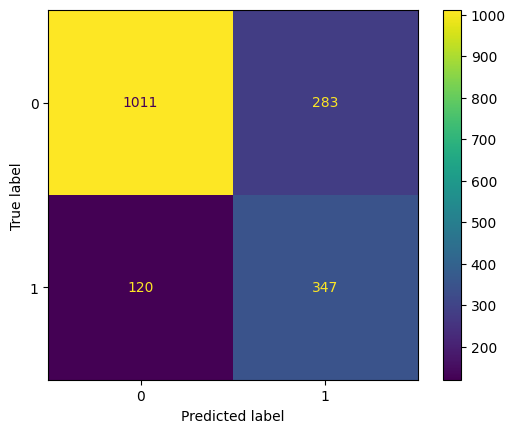

In [13]:
# получите предсказания для тестовой выборки
# ваш код здесь #
y_pred = pipeline.predict(X_val)

print('f1:', f1_score(y_val, y_pred).round(2))
print('roc_auc:', roc_auc_score(y_val, y_pred).round(2))

ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred)).plot()

X_tr_cross, X_val_cross, y_tr_cross, y_val_cross = train_test_split(data, data['target'], stratify=data['target'], random_state=123)
# Проведите кросс-валидацию #
scoring=['f1','roc_auc']
cv_res = cross_validate(pipeline, X_tr_cross,y_tr_cross, scoring=scoring, cv=3)
for key, value in cv_res.items():
    print(f'avg_{key}: {value.mean().round(2)}')

In [14]:
# заведите словарь со всеми метриками
metrics = {}

# посчитайте метрики из модуля sklearn.metrics
# err_1 — ошибка первого рода
# err_2 — ошибка второго рода
_, err1, _, err2 = confusion_matrix(y_val, y_pred, normalize='all').ravel()# ваш код здесь #
auc = roc_auc_score(y_val, y_pred).round(2)# ваш код здесь #
precision = precision_score(y_val, y_pred).round(2)# ваш код здесь #
recall = recall_score(y_val, y_pred).round(2)# ваш код здесь #
f1 = f1_score(y_val, y_pred).round(2)# ваш код здесь #
logloss = round(log_loss(y_val, y_pred),2)# ваш код здесь #

# запишите значения метрик в словарь
metrics["err1"] = err1.round(2)
metrics["err2"] = err2.round(2)
metrics["auc"] = auc
metrics["precision"] = precision
metrics["recall"] = recall
metrics["f1"] = f1
metrics["logloss"] = logloss

In [15]:
metrics

{'err1': 0.16,
 'err2': 0.2,
 'auc': 0.76,
 'precision': 0.55,
 'recall': 0.74,
 'f1': 0.63,
 'logloss': 8.25}

In [24]:

#EXPERIMENT_NAME = 'test_connection_experiment_SorAndy'#"churn_SorAndy"
EXPERIMENT_NAME = "churn_CBC_SorAndy"
RUN_NAME = "feature_selection_intersection"#"feature_selection_union"
REGISTRY_MODEL_NAME = 'CBC_featured'

In [25]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = 'https://storage.yandexcloud.net' #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env



TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}") 

Проверяем наличие эксперимента с Нашим названием

In [26]:
assert mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
#assert mlflow.get_run(run_id)
#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

Логируем тренировочный датасет, метрики и т.п. (кроме модели)

dataset = mlflow.data.from_pandas(data)
data_X_tr = mlflow.data.from_pandas(X_tr)
data_X_val = mlflow.data.from_pandas(X_val)


with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    mlflow.log_input(dataset, context="initial dataset")
    mlflow.log_input(data_X_tr, context="training_X")
    mlflow.log_input(data_X_val, context="training_target")
       

Делаем простое логирование МОДЕЛИ

In [19]:
text = "Это текстовый комментарий для логирования в MLflow."
dataset = mlflow.data.from_pandas(data)
data_X_tr = mlflow.data.from_pandas(X_tr)
data_X_val = mlflow.data.from_pandas(X_val)

In [27]:
code_paths = ['CBC_model.ipynb']
pip_requirements = "requirements.txt"
signature = mlflow.models.infer_signature(X_val, y_pred)
input_example = X_val[:10]
metadata = {'model_type': 'monthly'}

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    # ваш код здесь
    mlflow.log_artifact('/home/mle-user/mlflow/mle-mlflow/users_churn.csv', 'dataframe')
    mlflow.log_artifact('columns.txt', 'dataframe')
    mlflow.log_param('test_size', 0.25)
    mlflow.log_param('stratify','target')
    mlflow.log_metrics(stats)
    mlflow.log_metrics(metrics)
    mlflow.log_input(dataset, context="initial dataset")
    mlflow.log_input(data_X_tr, context="training_X")
    mlflow.log_input(data_X_val, context="val_X")


    model_info = mlflow.catboost.log_model(
        cb_model=CBR_model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        pip_requirements=pip_requirements,
        input_example=input_example,
        metadata=metadata,
        code_paths=code_paths,
        await_registration_for=60
		)
    mlflow.log_metrics(metrics)

2024/04/06 07:16:29 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.11.2, required: mlflow==2.7.1)
 - jupyterlab (current: uninstalled, required: jupyterlab==4.0.7)
 - psycopg (current: uninstalled, required: psycopg==3.1.12)
 - psycopg-binary (current: uninstalled, required: psycopg-binary==3.1.12)
 - psycopg-pool (current: uninstalled, required: psycopg-pool==3.2.1)
 - pandas (current: 2.1.3, required: pandas==2.0.1)
 - scikit-learn (current: 1.4.1.post1, required: scikit-learn==1.3.1)
 - catboost (current: 1.2.3, required: catboost==1.2.2)
 - optuna (current: uninstalled, required: optuna==3.4.0)
 - ipywidgets (current: uninstalled, required: ipywidgets==8.1.1)
 - seaborn (current: uninstalled, required: seaborn==0.13.0)
 - mlxtend (current: 0.23.1, required: mlxtend==0.23.0)
 - boto3 (current: 1.34.69, required: boto3==1.34.71)
To fix the mismatches, call `mlflow.pyfu

ЗАГРУЗКА МОДЕЛИ

In [24]:
CBC_model = mlflow.catboost.load_model(model_uri=model_info.model_uri) 
# создайте пайплайн
pipeline = Pipeline(
                    [
                    ('transformer', preprocessor),
                    ('model', CBC_model)
                    ]
                   )
# обучите пайплайн
# ваш код здесь #

model_predictions = pipeline.predict(X_val)

assert model_predictions.dtype == int

print(model_predictions[:10])

[1 1 1 0 0 1 0 0 0 0]


In [25]:
y_pred[0:10]

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0])

In [26]:
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.sklearn.log_model(preprocessor, "preprocessor") 

2024/04/05 05:39:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [27]:
client = mlflow.MlflowClient() 
name_filter = EXPERIMENT_NAME # напишите имя фильтра
model_num = 7 # напишите номер модели
filter_string = f"name = '{name_filter}'" # сформируйте строку для фильтрации модели
#models = client.search_model_versions(filter_string)


#model_version = models[0].version
#model_stage = models[-1].current_stage

#print(f"Текущая версия модели {REGISTRY_MODEL_NAME}: '{model_version}'")
#print(f"Текущая стадия модели {REGISTRY_MODEL_NAME}: '{model_stage}'")

print(f"Текущая версия модели {REGISTRY_MODEL_NAME}: 'xxxx'")
print(f"Текущая стадия модели {REGISTRY_MODEL_NAME}: 'yyyy'")

models = client.search_model_versions(
    filter_string=f"name = '{REGISTRY_MODEL_NAME}'"
)

for model in models:
    print(model) 



Текущая версия модели CBC_model_row: 'xxxx'
Текущая стадия модели CBC_model_row: 'yyyy'
<ModelVersion: aliases=[], creation_timestamp=1712295568156, current_stage='None', description='', last_updated_timestamp=1712295568156, name='CBC_model_row', run_id='bb41332d040b4e8ea67e1177db0c2c5e', run_link='', source='s3://s3-student-mle-20240226-38fc211d67/9/bb41332d040b4e8ea67e1177db0c2c5e/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='8'>
<ModelVersion: aliases=[], creation_timestamp=1711995825952, current_stage='None', description='', last_updated_timestamp=1711995825952, name='CBC_model_row', run_id='619e2429a5a94d87966e7f1910e4a553', run_link='', source='s3://s3-student-mle-20240226-38fc211d67/9/619e2429a5a94d87966e7f1910e4a553/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='7'>
<ModelVersion: aliases=[], creation_timestamp=1711697842829, current_stage='Staging', description='', last_updated_timestamp=1711700190289, 

ЛОГИРОВАНИЕ AUTOFEAT

In [28]:
cat_features = [
    'paperless_billing',
    'payment_method',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines',
]
num_features = ["monthly_charges", "total_charges"]

features = cat_features + num_features

In [31]:
features = ['type', 'paperless_billing',
            'payment_method', 'monthly_charges', 'total_charges',
            'internet_service', 'online_security', 'online_backup',
            'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
            'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines',
           ] # список признаков вашей модели
target = ['target'] # колонка с таргетом вашей модели

split_column = "begin_date"
test_size = 0.2

data= data.sort_values(by=[split_column])

X_train, X_test, y_train, y_test = train_test_split(
    data[features],
    data[target],
    test_size=test_size,
    shuffle=False,
) 

In [32]:
from autofeat import AutoFeatRegressor, AutoFeatClassifier

In [33]:
transformations = ("1/", "log", "abs", "sqrt")# , "exp", "^2", "^3", "1+", "1-", "sin", "cos", "exp-", "2^"] 

afc = AutoFeatClassifier(categorical_cols = cat_features,
                         transformations = transformations,
                         feateng_steps=1,
                         n_jobs=-1
                        )

In [34]:
#X_train_features = afc.fit_transform(X_train, y_train) # ваш код здесь # примените автоэнкодер признаков для данных для обучения
#X_test_features = afc.transform(X_test) # ваш код здесь # примените автоэнкодер признаков для данных для валидации/теста

In [35]:
artifact_path = "afc"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    afc_info = mlflow.sklearn.log_model(afc, artifact_path=artifact_path) 

RANDOM FOREST WITH sequential_feature_selection

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


In [8]:
with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
				
				# извлекаем все строки, полученные в результате выполнения запроса
        data = cur.fetchall()

				# получаем список имён столбцов из объекта курсора
        columns = [col[0] for col in cur.description]

In [1]:
df = pd.DataFrame(data, columns=columns)
df = df.dropna(how='all')
 
 
# Selecting the categorical columns
obj_df = df.select_dtypes(include="object")
cat_columns = obj_df.columns
 
# Initialize the OneHotEncoder
encoder_oh = OneHotEncoder()
 
# Fit and transform the categorical features
encoded_features = encoder_oh.fit_transform(df[cat_columns]).toarray()
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder_oh.get_feature_names_out())
 
# Drop the original categorical columns from the original DataFrame
df.drop(columns=cat_columns, inplace=True)
assert len(df) == len(encoded_features_df), "Row mismatch between df and encoded_features_df"
# Concatenate the original DataFrame (without categorical columns) and the new encoded features DataFrame
df = pd.concat([df.reset_index(drop=True), encoded_features_df.reset_index(drop=True)], axis=1)
 
 
X = df.drop(columns=['end_date', 'begin_date', 'target']) # or df.drop(target, axis=1)
y = df['target']
 
X_train_features, X_test, y_train, y_test = train_test_split(
X,
y,
test_size=0.2,
shuffle=False,
)


NameError: name 'pd' is not defined

In [10]:
estimator = RandomForestClassifier(n_estimators=50)
 
sfs = SFS(estimator, k_features=3, forward=True, floating=False, scoring='roc_auc', cv=2, n_jobs=-1)
 
sbs = SFS(estimator, k_features=3, forward=False, floating=False, scoring='roc_auc', cv=2, n_jobs=-1)
 
sfs = sfs.fit(X_train_features, y_train)
sbs = sbs.fit(X_train_features, y_train)
 
top_sfs = sfs.k_feature_names_# ваш код здесь #
top_sbs = sbs.k_feature_names_# ваш код здесь #
 
print('\\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)
 
print('\\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)
 
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T
 
if not os.path.exists(FS_ASSETS):
    os.mkdir(FS_ASSETS)
 
sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv")
 
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
 
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
 
plt.savefig("FS_ASSETS/sfs.png")
 
fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
 
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()
 
plt.savefig("FS_ASSETS/sbs.png")
 
interc_features = list(set(top_sbs) & set(top_sfs))
union_features = list(set(top_sbs) | set(top_sfs))

/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


: 

In [ ]:
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifacts(FS_ASSETS)